In [1]:
import pandas as pd
import numpy as np
from math import isnan
from IPython.display import display, HTML
import matplotlib.pyplot as plt
from itertools import chain
from src.swap_utils import get_pool_value_by_coin

from src.data_extractors import get_pools, get_prices, get_price_enriched

#### Get Bostrom and Osmosis Pools Data

In [2]:
pools_df = get_pools(display_data=False)
pools_df = \
    pools_df[
        (pools_df.network == 'bostrom') |
        (pools_df.reserve_coin_denoms.map(
            lambda denoms: denoms[0] == 'boot in osmosis' or denoms[1] == 'boot in osmosis'))]
pools_df

,network,id,type_id,balances,swap_fee,reserve_coin_denoms
0,bostrom,1,1,"[{'denom': 'boot', 'amount': '2420970317712'},...",0.003,"[boot, hydrogen]"
1,bostrom,2,1,"[{'denom': 'boot', 'amount': '10665693618'}, {...",0.003,"[boot, milliampere]"
2,bostrom,3,1,"[{'denom': 'boot', 'amount': '37564103659'}, {...",0.003,"[boot, tocyb]"
3,bostrom,4,1,"[{'denom': 'hydrogen', 'amount': '191306734368...",0.003,"[hydrogen, tocyb]"
4,bostrom,5,1,"[{'denom': 'hydrogen', 'amount': '928531530221...",0.003,"[hydrogen, milliampere]"
5,bostrom,6,1,"[{'denom': 'hydrogen', 'amount': '543453059209...",0.003,"[hydrogen, millivolt]"
6,bostrom,7,1,"[{'denom': 'hydrogen', 'amount': '180428190999...",0.003,"[hydrogen, uosmo in bostrom]"
7,bostrom,8,1,[],0.003,"[hydrogen, deprecated uatom in bostrom]"
8,bostrom,9,1,[],0.003,"[uosmo in bostrom, deprecated uatom in bostrom]"
9,bostrom,10,1,"[{'denom': 'milliampere', 'amount': '140528359...",0.003,"[milliampere, millivolt]"


#### Calculate Prices

In [3]:
price_df = get_prices(pools_df=pools_df, display_data=True)

,liquidpussy,udsm in bostrom,aevmos in bostrom,uosmo in bostrom,ujuno in bostrom,tocyb,uosmo,hydrogen,pussy in bostrom,boot in osmosis,wei gravETH in bostrom,uatom in bostrom,pussy,boot,deprecated uatom in bostrom,milliampere,uatom in osmosis,ugraviton in bostrom,liquidpussy in bostrom,millivolt
liquidpussy,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.136154,NaN,NaN,5212.430596,NaN,NaN,NaN,74647.19709
udsm in bostrom,NaN,1,NaN,NaN,NaN,NaN,NaN,0.130437,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
aevmos in bostrom,NaN,NaN,1,NaN,NaN,NaN,NaN,9563118817.404087,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
uosmo in bostrom,NaN,NaN,NaN,1,NaN,NaN,1,0.004141,NaN,NaN,NaN,13.241576,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ujuno in bostrom,NaN,NaN,NaN,NaN,1,NaN,NaN,0.002832,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
tocyb,NaN,NaN,NaN,NaN,NaN,1,NaN,0.161858,NaN,NaN,NaN,NaN,NaN,0.435433,NaN,NaN,NaN,NaN,NaN,NaN
uosmo,NaN,NaN,NaN,1,NaN,NaN,1,NaN,NaN,0.011574,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
hydrogen,NaN,7.62063,0.0,240.049841,350.979354,6.141248,NaN,1,0.000614,NaN,NaN,3154.066895,NaN,2.656758,NaN,3930.918642,NaN,3.098702,0.000222,36280.521185
pussy in bostrom,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1619.971488,1,NaN,NaN,5182502.074515,1,4308.962967,NaN,NaN,NaN,NaN,NaN,NaN
boot in osmosis,NaN,NaN,NaN,NaN,NaN,NaN,86.05187,NaN,NaN,1,NaN,NaN,NaN,1,NaN,NaN,1178.579378,NaN,NaN,NaN


#### Prices without References to the Networks

In [4]:
price_enriched_df = get_price_enriched(price_df=price_df, display_data=True)

,liquidpussy,udsm in bostrom,aevmos in bostrom,uosmo in bostrom,ujuno in bostrom,tocyb,uosmo,hydrogen,pussy in bostrom,boot in osmosis,wei gravETH in bostrom,uatom in bostrom,pussy,boot,deprecated uatom in bostrom,milliampere,uatom in osmosis,ugraviton in bostrom,liquidpussy in bostrom,millivolt
liquidpussy,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.136154,NaN,NaN,5212.430596,NaN,NaN,NaN,74647.19709
udsm in bostrom,NaN,1,NaN,NaN,NaN,NaN,NaN,0.130437,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
aevmos in bostrom,NaN,NaN,1,NaN,NaN,NaN,NaN,9563118817.404087,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
uosmo in bostrom,NaN,NaN,NaN,1,NaN,NaN,1,0.004141,NaN,0.011574,NaN,13.241576,NaN,0.011574,NaN,NaN,13.241576,NaN,NaN,NaN
ujuno in bostrom,NaN,NaN,NaN,NaN,1,NaN,NaN,0.002832,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
tocyb,NaN,NaN,NaN,NaN,NaN,1,NaN,0.161858,NaN,0.435433,NaN,NaN,NaN,0.435433,NaN,NaN,NaN,NaN,NaN,NaN
uosmo,NaN,NaN,NaN,1,NaN,NaN,1,0.004141,NaN,0.011574,NaN,13.241576,NaN,0.011574,NaN,NaN,13.241576,NaN,NaN,NaN
hydrogen,NaN,7.62063,0.0,240.049841,350.979354,6.141248,240.049841,1,0.000614,2.656758,NaN,3154.066895,NaN,2.656758,NaN,3930.918642,3154.066895,3.098702,0.000222,36280.521185
pussy in bostrom,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1619.971488,1,4308.962967,NaN,5182502.074515,1,4308.962967,NaN,NaN,5182502.074515,NaN,NaN,NaN
boot in osmosis,NaN,NaN,NaN,86.05187,NaN,2.282805,86.05187,0.374144,0.000231,1,NaN,1178.579378,NaN,1,NaN,1469.389634,1178.579378,NaN,NaN,13544.585946


#### Get Pools Liquidity

network,id,reserve_coin_denoms,"liquidity, GH"
osmosis,596,"[uatom in osmosis, boot in osmosis]","1,858.8"
osmosis,597,"[boot in osmosis, uosmo]",782.8
bostrom,3,"[liquidpussy, millivolt]","31,890.7"
bostrom,1,"[boot, hydrogen]","12,902.6"
bostrom,12,"[hydrogen, uatom in bostrom]","11,048.2"
bostrom,2,"[liquidpussy, milliampere]","9,156.3"
bostrom,18,"[uosmo in bostrom, uatom in bostrom]","8,312.5"
bostrom,4,"[milliampere, millivolt]","5,958.1"
bostrom,7,"[hydrogen, uosmo in bostrom]","3,608.6"
bostrom,23,"[uatom in bostrom, wei gravETH in bostrom]","2,380.9"


Total liquidity: 94,713 GH


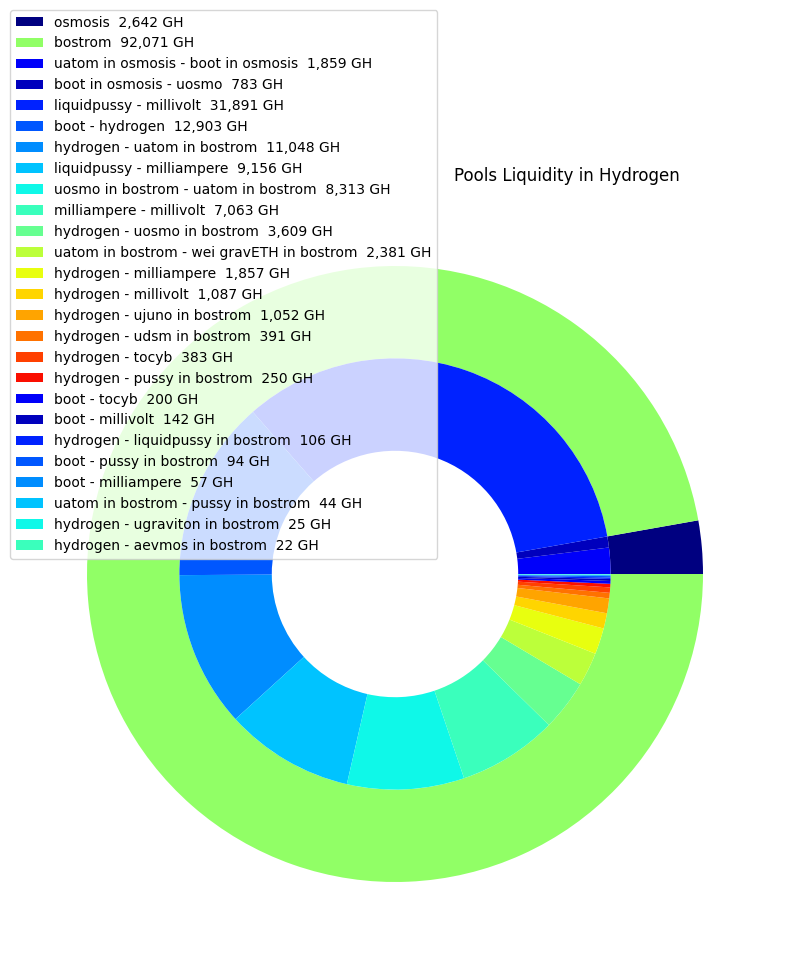

In [5]:
def get_pool_liquidity(balances: list, target_denom: str = 'hydrogen', main_liquidity_denom: str = 'hydrogen',
                       price_enriched_df: pd.DataFrame = price_enriched_df) -> float:
    if not balances:
        return 0
    denoms = [item['denom'] for item in balances]
    balances_dict = {item['denom']: int(item['amount']) for item in balances}
    if target_denom in denoms:
        return balances_dict[target_denom] * 2
    elif not isnan(price_enriched_df.loc[target_denom, denoms[0]]):
        return balances_dict[denoms[0]] * price_enriched_df.loc[target_denom, denoms[0]] * 2
    elif not isnan(price_enriched_df.loc[target_denom, denoms[1]]):
        return balances_dict[denoms[1]] * price_enriched_df.loc[target_denom, denoms[1]] * 2
    elif not isnan(price_enriched_df.loc[target_denom, main_liquidity_denom]) and not isnan(
            price_df.loc[main_liquidity_denom, denoms[0]]):
        return balances_dict[denoms[0]] * price_enriched_df.loc[target_denom, main_liquidity_denom] * \
               price_enriched_df.loc[main_liquidity_denom, denoms[0]] * 2
    elif not isnan(price_enriched_df.loc[target_denom, main_liquidity_denom]) and not isnan(price_df.loc[main_liquidity_denom, denoms[1]]):
        return balances_dict[denoms[1]] * price_enriched_df.loc[target_denom, main_liquidity_denom] * \
               price_enriched_df.loc[main_liquidity_denom, denoms[1]] * 2
    return 0


pools_df['liquidity, GH'] = pools_df['balances'].map(get_pool_liquidity) / 1e9
display(HTML(
    pools_df[(pools_df.network != 'osmosis') | (pools_df.id != 1)][
        ['network', 'id', 'reserve_coin_denoms', 'liquidity, GH']]
    .sort_values(['network', 'liquidity, GH'], ascending=False)
    .to_html(index=False, notebook=True, show_dimensions=False, float_format='{0:7,.1f}'.format)
    .replace('text-align: left;', 'text-align: right')
    .replace('<tr>', '<tr align="right">')))

print(
    f"Total liquidity: {round(sum(pools_df[(pools_df.network != 'osmosis') | (pools_df.id != 1)]['liquidity, GH'])):>,} GH")

fig, ax = plt.subplots(figsize=(10, 10))
size = 0.3
cm = plt.get_cmap("jet", 20)
cout = cm(np.arange(2) * 10)

pools_df['denoms'] = pools_df.reserve_coin_denoms.map(lambda x: f'{x[0]} - {x[1]}')
outer = pools_df.groupby('network')[
    'liquidity, GH'].sum().sort_values(ascending=True)
inner = pools_df[pools_df['liquidity, GH'] > 1].groupby(
    ['network', 'denoms'])['liquidity, GH'].sum().sort_values(ascending=False).sort_index(
        axis=0, level=[0], ascending=[False], inplace=False)
inner_labels = ['{1}  {2:>,.0f} GH'.format(i[0], i[1], j) for i, j in zip(inner.index, inner)]
outer_labels = ['{0}  {1:>,.0f} GH'.format(i, j) for i, j in zip(outer.index, outer)]
ax.pie(outer.values.flatten(), radius=1,
       labeldistance=0.73,
       wedgeprops=dict(width=size), colors=cout)
cin = cm(np.array([2, 1, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 15, 16, 17]))
ax.pie(inner.values.flatten(),
       radius=1-size,
       wedgeprops=dict(width=size),
       labeldistance=0.5, colors=cin)

ax.set_title('Pools Liquidity in Hydrogen                   ', loc='right')

plt.legend(outer_labels + inner_labels, loc=(0, 0.52))
handles, labels = ax.get_legend_handles_labels()
plt.show()

pools_df.to_csv('data/pools_liquidity.csv')

### Liquidity by Coins

Liquidity by Coins


coin,network,liquidity,"liquidity, GH"
millivolt,bostrom,5.359956e+08,1.944620e+13
hydrogen,bostrom,1.636596e+13,1.636596e+13
uatom in bostrom,bostrom,3.434179e+09,1.083163e+13
milliampere,bostrom,2.305777e+09,9.063821e+12
boot,bostrom,2.513588e+12,6.677993e+12
uosmo in bostrom,bostrom,2.480787e+10,5.955124e+12
boot in osmosis,osmosis,4.956530e+11,1.316830e+12
uatom in osmosis,osmosis,2.946683e+08,9.294037e+11
ujuno in bostrom,bostrom,1.494126e+09,5.244074e+11
uosmo,osmosis,1.708543e+09,4.101355e+11


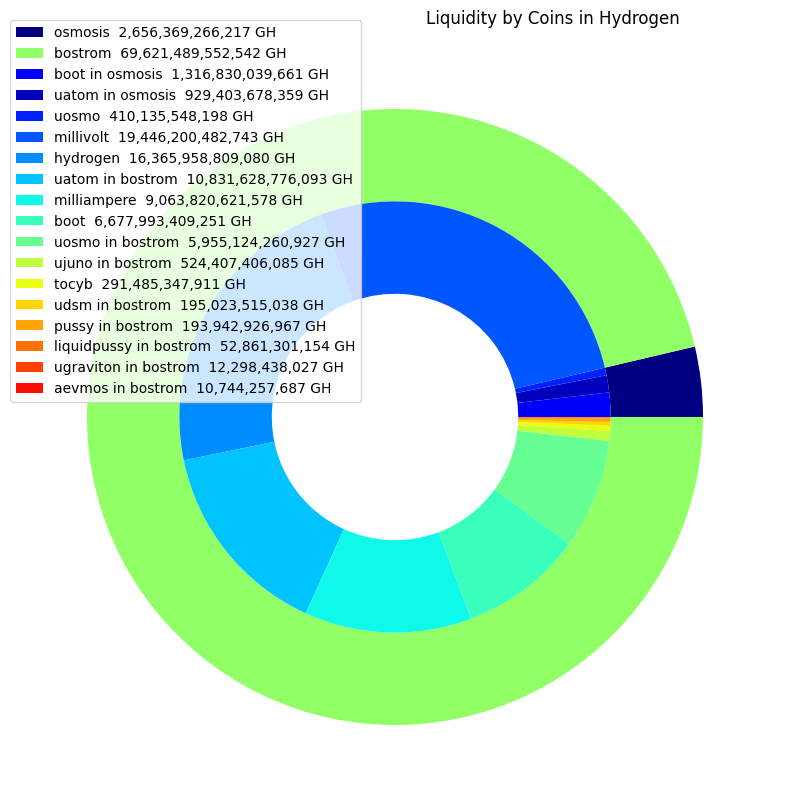

In [6]:
coin_list = set(chain(*pools_df.reserve_coin_denoms.to_list()))
coin_liquidity_data = []
print('Liquidity by Coins')
for coin_denom in coin_list:
    pools_df.loc[:, f'{coin_denom}_balance'] = pools_df.balances.map(lambda x: get_pool_value_by_coin(pool_balances=x, coin_denom=coin_denom))
    coin_liquidity_data.append({
        'coin': coin_denom,
        'network': 'osmosis' if coin_denom == 'uosmo' or coin_denom[-7:] == 'osmosis' else 'bostrom',
        'liquidity': pools_df[f"{coin_denom}_balance"].sum(),
        'liquidity, GH': pools_df[f"{coin_denom}_balance"].sum() * price_enriched_df.loc['hydrogen', coin_denom]})
coin_liquidity_df = pd.DataFrame(coin_liquidity_data).sort_values('liquidity, GH', ascending=False).reset_index().drop(columns=['index'])
display(HTML(
    coin_liquidity_df.to_html(
                index=False, notebook=True, show_dimensions=False)))

fig, ax = plt.subplots(figsize=(10, 10))
size = 0.3
cm = plt.get_cmap("jet", 20)
cout = cm(np.arange(2) * 10)

outer = coin_liquidity_df.groupby('network')[
    'liquidity, GH'].sum().sort_values(ascending=True)
inner = coin_liquidity_df[coin_liquidity_df['liquidity, GH'] > 1].groupby(
    ['network', 'coin'])['liquidity, GH'].sum().sort_values(ascending=False).sort_index(axis=0, level=[0],
                                                                                             ascending=[False],
                                                                                             inplace=False)
inner_labels = ['{1}  {2:>,.0f} GH'.format(i[0], i[1], j) for i, j in zip(inner.index, inner)]
outer_labels = ['{0}  {1:>,.0f} GH'.format(i, j) for i, j in zip(outer.index, outer)]
ax.pie(outer.values.flatten(), radius=1,
       labeldistance=0.73,
       wedgeprops=dict(width=size), colors=cout)
cin = cm(np.array([2, 1, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 15, 16, 17]))
ax.pie(inner.values.flatten(), radius=1 - size,
       wedgeprops=dict(width=size),
       labeldistance=0.5, colors=cin)

ax.set_title('Liquidity by Coins in Hydrogen                   ', loc='right')

plt.legend(outer_labels + inner_labels, loc=(0, 0.52))
handles, labels = ax.get_legend_handles_labels()
plt.show()

coin_liquidity_df.to_csv('data/coins_liquidity.csv')